In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy

from datetime import datetime
from matplotlib.ticker import MaxNLocator, MultipleLocator
from numpy import array
from pandas import DataFrame
from pandas.plotting import register_matplotlib_converters
from tkinter import filedialog
from tkinter import *

register_matplotlib_converters()

%matplotlib inline

In [2]:
def get_DSECO_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data\Master_files", title = "Select DSECO master file",\
                        filetypes = (("Dseco files","*.CORRECTED"),("Dseco files","*.corrected"),("all files","*.*")))
    root.destroy()

    return(root.filename)

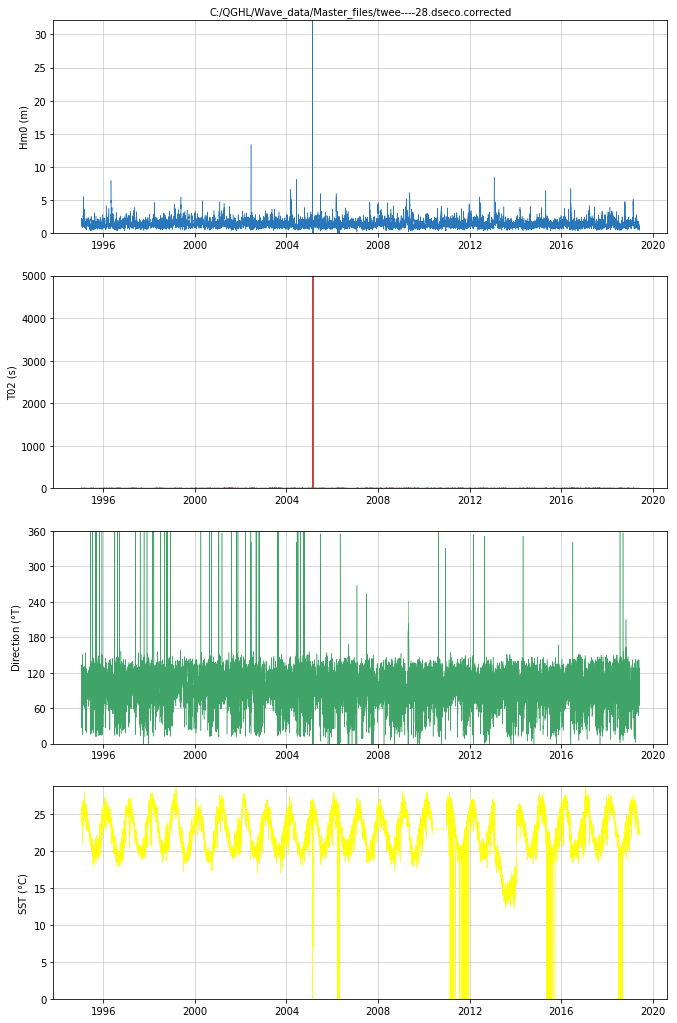

Program finished


In [3]:
# Create a DT based on the structure type of the SECO Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro

rectype = np.dtype([
                    ('Procid','B',(12,)),
                    ('Loc','i'),
                    ('date_val','i2',(12)),
                    ('Elapse','i2',(2)),
                    ('Hm0','f'),('T02','f'),('Pdens','f'),('Temp','f'),
                    ('Vacc','f'),('Xacc','f'),('Yacc','f'),
                    ('Orient','f'),('Inclin','f'),
                    ('Tp_buoy','f'),('Avg_dir','f'),('Peak_dir','f'),
                    ('Corr_to_True','f'),
                    ('jdirn', 'i2', (64)),('jrpower', 'i2', (64)),('jspread', 'i2', (64)),                     
                   ])


# Parameters in Dparam are:
#     hm0,t02,pdens,temp,vacc,xacc,yacc,orient,inclin,tp_buoy,avg_dir,peak_dir, 

# Get name of input DSECO file
Input_DSECO_File = get_DSECO_file()

# Open file
f = open(Input_DSECO_File)

# Read data from the Binary file into a DF based on the structure in the DT
data = np.fromfile(f, rectype)
recs = DataFrame.from_records(np.array(data).tolist())

recs.columns = ['Procid','Loc','date_val','Elapse',
                        'Hm0','T02','Pdens','Temp',
                        'Vacc','Xacc','Yacc',
                        'Orient','Inclin',
                        'Tp_buoy','Avg_dir','Peak_dir',
                        'Corr_to_True','jdirn','jrpower','jspread']

 # Locate and remove errant zero's from data
zero_data = recs.loc[recs.date_val.apply(lambda x: x[0])==0].index

if len(zero_data) > 0:
    recs_zero = recs    # make a copy to locate where the zeros occur
    date_string =  [[recs.loc[zero_data[0]-1].date_val.tolist()][0][i] for i in range(0,10,2)]
    ' '.join(str(p) for p in [date_string])
    first_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
        +':'+str(date_string[4])
    date_string =  [[recs.loc[zero_data[-1]+1].date_val.tolist()][0][i] for i in range(0,10,2)]
    ' '.join(str(p) for p in [date_string])
    last_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
        +':'+str(date_string[4])
    print('Alert: ',len(zero_data),' Zero\'s found (and removed) between ',first_val,' and ',last_val)

    recs = recs.loc[recs.date_val.apply(lambda x: x[0])!=0]    # remove the zeros from the df

# Convert date/time column data into Dates and times
Record_time = pd.DataFrame(recs.date_val.values.tolist(), \
        columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

# Correct dates for two-digit year 
Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

# Insert Date column at start of DF
recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

#%matplotlib notebook

def re_zoom(event):
    zoom = 1.0
    for ax in event.canvas.figure.axes: # get the change in scale
        nx = ax.get_xlim()
        ox = ax.old_xlim
        if ox != nx:                    # of axes that have changed scale
            zoom = (nx[1]-nx[0])/(ox[1]-ox[0])

    for ax in event.canvas.figure.axes: # change the scale
        nx = ax.get_xlim()
        ox = ax.old_xlim
        if ox == nx:                    # of axes that need an update
            mid = (ox[0] + ox[1])/2.0
            dif = zoom*(ox[1] - ox[0])/2.0
            nx = (mid - dif, mid + dif)
            ax.set_xlim(*nx)
        ax.old_xlim = nx
    if zoom != 1.0:
        event.canvas.draw()             # re-draw the canvas (if required)

#ax1 = plt.figure(figsize=(10,15))
fig, ax = plt.subplots(4, 1, figsize=(11,18), sharex=True, sharey=True)
ax1 = plt.subplot(4,1,1)
ax1.set_title(Input_DSECO_File,fontsize=10)
ax1.set_ylabel("Hm0 (m)")
y_max = max(recs.Hm0)
ax1.set_ylim(bottom=0,top=y_max)
ax1.plot(recs.index,recs.Hm0,linewidth=0.5,c='xkcd:bluish')
ax1.grid(True,linewidth=0.5)

ax2 = plt.subplot(4,1,2, sharex=ax1)
ax2.set_ylabel("T02 (s)")
y_max = max(recs.T02)
ax2.set_ylim(bottom=0,top=y_max)
ax2.plot(recs.index,recs.T02,linewidth=0.5,c='xkcd:reddish')
ax2.grid(True,linewidth=0.5)

ax3 = plt.subplot(4,1,3, sharex=ax1)
ax3.set_ylabel("Direction ($\degree$T)")
ax3.set_ylim(bottom=0,top=360)
ax3.yaxis.set_major_locator(MaxNLocator(6))
ax3.plot(recs.index,recs.Peak_dir+recs.Corr_to_True,linewidth=0.5,c='xkcd:greenish')
ax3.grid(True,linewidth=0.5)

ax4 = plt.subplot(4,1,4, sharex=ax1)
ax4.set_ylabel("SST ($\degree$C)")
y_max = max(recs.Temp)
ax4.set_ylim(bottom=0,top=y_max)
ax4.plot(recs.index,recs.Temp,linewidth=0.5,c='xkcd:yellow')
ax4.grid(True,linewidth=0.5)

ax1.old_xlim = ax1.get_xlim()  # store old values so changes
ax2.old_xlim = ax2.get_xlim()  # store old values so changes
ax3.old_xlim = ax3.get_xlim()  # store old values so changes
ax4.old_xlim = ax4.get_xlim()  # store old values so changes

plt.connect('motion_notify_event', re_zoom)  # for right-click pan/zoom
plt.connect('button_release_event', re_zoom) # for rectangle-select zoom
plt.show()
            
#%matplotlib inline

print('Program finished')

# Keep next line in code - for use when detecting zero-date error
# recs.loc[recs.date_val.apply(lambda x: x[0])==0]


In [ ]:
def close():
    global lb, master, item1
    try:
        item1 = lb.get(lb.curselection())
    except:
        item1 = 'Nothing selected'
    master.destroy()
    return(item1)
###############################################################

from matplotlib.ticker import MultipleLocator

date_entry = input('Enter a date to view Spectra (i.e. YYYY MM DD) ')
year, month, day = map(int, date_entry.split(' '))
date = datetime(year, month, day)

try:
    start_date = recs.loc[recs.index.values==np.datetime64(date)]
    end_date = recs.loc[recs.index.values==np.datetime64(date) + np.timedelta64(1,'D')]
except:
    print("Can't find ", date)
    
records = recs.loc[start_date.index.values[0]:end_date.index.values[0]]

freq = []
        
for i in range(64):
            if i<16:
                freq.append(0.025+i*0.005) 
            else:
                freq.append(0.11+(i-16)*0.01)
                
item1 = ''

while item1 != 'EXIT':
    master = Tk()   
    master.title("SELECT DATE/TIME")

    scrollbar = Scrollbar(master, orient="vertical")
    lb = Listbox(master, width=30, height=50, font=('Aerial',10),justify='center',yscrollcommand=scrollbar.set)
    scrollbar.config(command=lb.yview)

    scrollbar.pack(side="right", fill="y")
    lb.pack(side="left",fill="both", expand=True)

    lb.insert('end', 'EXIT')
    for item in records.index.values:
        lb.insert('end', item)
    lb.insert('end', 'EXIT')
    lb.focus()

    b = Button(master, text = "OK", command = close).pack()

    try:
        master.mainloop()

    except:
        pass

    if (item1 != 'EXIT'):
        print(item1)
        
        jrpower = recs[item1].jrpower
        pdens = recs[item1].Pdens.values[0]
        npower = np.exp(-jrpower.values[0]/200.)*pdens
        
#        try:
        fig, ax1 = plt.subplots(figsize=(10,8),dpi=100)

        ax1.set_title(Input_DSECO_File+'\n'+item1,fontsize=12)

        ax1.set_xlim(left=0,right=0.65)
        ax1.set_ylim(bottom=0,top=pdens)
        ax1.set_xlabel('Frequency (Hz)',fontsize=12); plt.xlim(0, max(freq)) # Display Frequency on X-axis
        ax1.set_ylabel('Spectral density ($m^2$/Hz)',fontsize=12)
        ax1.grid(True,axis='both',linestyle=':')
        ax1.plot(freq,npower,color='r',marker='o',markersize=4)
##        ax1.fill(freq,npower*pdens,c='xkcd:light pink')
        ax1.text(0.45,pdens*0.9,'Hm0 = '+"%.2f" % recs.loc[item1].Hm0+'m',fontsize=10,horizontalalignment='left')
        ax1.text(0.45,pdens*0.85,'T02  = '+"%.2f" % recs.loc[item1].T02+'s',fontsize=10,horizontalalignment='left')
        ax1.text(0.45,pdens*0.8,'Tp  = '+"%.2f" % recs.loc[item1].Tp_buoy+'s',fontsize=10,horizontalalignment='left')
        ax1.text(0.45,pdens*0.75,'Dir = '+"%.2f" % (recs.loc[item1].Peak_dir+ recs.loc[item1].Corr_to_True)+'$^\circ$T',fontsize=10,horizontalalignment='left')
        ax1.text(0.45,pdens*0.7,'SST = '+"%.2f" % recs.loc[item1].Temp+'$^\circ$C',fontsize=10,horizontalalignment='left')

        ax2 = ax1.twinx()

        dw_direction = recs[item1].jdirn.values[0] * 360. / 256.  + recs[item1].Corr_to_True.values[0] 
        dw_spread = recs[item1].jspread.values[0] * 0.4476

        ax2.set_ylim(bottom=0,top=360)
        ax2.set_yticks(np.arange(0, 390, 30))

#            ax2.set_xlabel('Frequency (Hz)',fontsize=12); plt.xlim(0, max(freq)) # Display Frequency on X-axis
        ax2.set_ylabel(r"Direction ($\degree$ True)",fontsize=12)
##        ax2.grid(True,axis='both',linestyle=':')

        ax2.plot(freq,dw_direction,c='xkcd:purple',marker='o',markersize=4)
        ax2.plot(freq,dw_direction - dw_spread,linestyle=':',c='xkcd:purple')
        ax2.plot(freq,dw_direction + dw_spread,linestyle=':',c='xkcd:purple')

        fig.tight_layout() 
        plt.show()
            
#        except:
#            print('ALERT: Can not display record!')
        
    else:
        print('Program terminated by user')


In [123]:
max(np.exp(-jrpower.values[0]/200.)*pdens)

2.1645190715789795

In [126]:
npower/pdens

array([1.54922573e-03, 1.84550929e-03, 1.83630478e-03, 4.33948327e-03,
       6.60452671e-03, 1.94482147e-02, 2.77366676e-02, 1.95456993e-02,
       2.22591972e-02, 1.81333952e-02, 3.32068201e-02, 1.78634242e-02,
       5.55762126e-02, 7.13612696e-02, 1.33988675e-01, 2.02908529e-01,
       1.00000000e+00, 8.91366144e-01, 6.47264667e-01, 4.89192112e-01,
       3.55226381e-01, 2.17621057e-01, 1.41564477e-01, 1.37380614e-01,
       9.53691622e-02, 7.80816660e-02, 7.39031372e-02, 4.41571684e-02,
       3.49093702e-02, 4.64211549e-02, 3.12730054e-02, 3.23869408e-02,
       3.01973834e-02, 1.44798102e-02, 2.07543379e-02, 2.10679995e-02,
       1.08347144e-02, 8.73864619e-03, 6.12730663e-03, 1.06734066e-02,
       8.78244883e-03, 7.52142247e-03, 3.66106936e-03, 5.04176026e-03,
       3.21476828e-03, 2.99743007e-03, 3.32927739e-03, 2.60584052e-03,
       2.23168137e-03, 2.71218689e-03, 2.17658096e-03, 2.24286772e-03,
       1.92082596e-03, 1.48105590e-03, 1.14769465e-03, 1.63681991e-03,
      

In [98]:
pdens.values

array([1.23022676])